In [1]:
print(__doc__)

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.datasets import load_digits

from sklearn.utils import check_random_state
from sklearn.model_selection import KFold

from sklearn.linear_model import LogisticRegression
from sklearn.utils import check_random_state
from sklearn.metrics import accuracy_score

pd.options.display.float_format = "{:.1f}".format

Automatically created module for IPython interactive environment


In [2]:
def retrieve_data_recid():
    attributes = ['MarriageStatus','age','juv_fel_count', 'juv_misd_count', 'juv_other_count','priors_count', 'days_b_screening_arrest','c_days_from_compas','c_charge_degree']
    bias = 'race'
    target = 'two_year_recid'

    np.random.seed(42)

    data = pd.read_csv("https://raw.githubusercontent.com/WenxuanHuang/Active-Learning-Performance-Benchmarking/main/RecidivismData_Normalized.csv", sep=',')
    data_col = data.columns
    df = data[(data[bias]==2)|(data[bias]==3)].copy().values

    kf = KFold(n_splits=4) #differ from original method
    for train_index, test_index in kf.split(df):
        train, test = df[train_index], df[test_index]
        # print("Size of X_train_full, X_test:", train.shape, test.shape)

    df_train = pd.DataFrame(data=train, columns=data_col)
    df_test = pd.DataFrame(data=test, columns=data_col)

    labeled = df_train.groupby(target, group_keys=False).apply(lambda x: x.sample(n=5, random_state = 42)) # ten sample in total labeled initially
    df_X_labeled = labeled[attributes]
    df_y_labeled = labeled[target]
    X_labeled = df_X_labeled.values
    y_labeled = df_y_labeled.values.astype('int64')
    b_labeled = labeled[bias].values-2
    (row_size, col_size) = X_labeled.shape

    unlabeled = df_train.drop(df_X_labeled.index)
    df_X_unlabeled = unlabeled[attributes]
    df_y_unlabeled = unlabeled[target]
    X_unlabeled = df_X_unlabeled.values
    y_unlabeled = df_y_unlabeled.values.astype('int64')
    b_unlabeled = unlabeled[bias].values-2

    X_test = df_test[attributes].values
    y_test = df_test[target].values
    y_test=y_test.astype('int')
    b_test = df_test[bias].values-2

    X_fair_est = X_unlabeled
    y_fair_est = y_unlabeled
    b_fair_est = b_unlabeled
    
    return (X_labeled, y_labeled, b_labeled, row_size, col_size, X_unlabeled, y_unlabeled, b_unlabeled, X_test, y_test, b_test, X_fair_est, y_fair_est, b_fair_est)

In [3]:
class BaseModel(object):

    def __init__(self):
        pass

    def fit_predict(self):
        pass

class LogModel(BaseModel):

    def fit_predict(self, X_labeled, y_labeled, X_test, y_test):
        self.classifier = LogisticRegression(
            solver='liblinear'
            )
        self.classifier.fit(X_labeled, y_labeled)
        # self.y_test_predicted = self.classifier.predict(X_test)
        # self.y_unlabeled_predicted = self.classifier.predict(X_unlabeled)
        self.y_test_score = self.classifier.score(X_test, y_test)
        return (X_labeled, X_test, self.y_test_score)

In [4]:
class TrainModel:

    def __init__(self, model_object):        
        self.accuracies = []
        self.model_object = model_object()        

    def print_model_type(self):
        print (self.model_object.model_type)

    def train(self, X_labeled, y_labeled, X_test, y_test):
        t0 = time.time()
        (X_labeled, X_test, self.y_test_score) = \
            self.model_object.fit_predict(X_labeled, y_labeled, X_test, y_test)
        self.run_time = time.time() - t0
        return (X_labeled, X_test)

    def get_test_accuracy(self, i):
        classif_rate = self.y_test_score * 100
        self.accuracies.append(classif_rate)               
        # print('--------------------------------')
        # print('Iteration:',i)
        # print("Accuracy rate is %f " % (classif_rate))    
        # print('--------------------------------')

In [5]:
class QueryFunction(object):

    def __init__(self):
        pass

    def pool_select(self):
        pass


# class RandomSelection(QueryFunction):

#     @staticmethod
#     def pool_select(probas_val, batch_size):
#         random_state = check_random_state(0)
#         # probas_val.shape[0] is the size of validation set
#         selection = np.random.choice(probas_val.shape[0], batch_size, replace=False)
#         # print('uniques chosen:',np.unique(selection).shape[0],'<= should be equal to:',batch_size)
#         return selection


# class EntropySelection(QueryFunction):

#     @staticmethod
#     def pool_select(probas_val, batch_size):
#         e = (-probas_val * np.log2(probas_val)).sum(axis=1)
#         selection = (np.argsort(e)[::-1])[:batch_size]
#         return selection

# class MinStdSelection(QueryFunction):

#     # select the samples where the std is smallest. There is uncertainty regarding the relevant class
#     # and then train on these "hard" to classify samples.
#     @staticmethod
#     def pool_select(probas_val, batch_size):
#         std = np.std(probas_val * 100, axis=1) 
#         selection = std.argsort()[:batch_size]
#         selection = selection.astype('int64')
#         print('std',std.shape,std)
#         print('selection',selection, selection.shape, std[selection])
#         return selection

# class LeastConfidenceSelection(QueryFunction):

#     @staticmethod
#     def pool_select(probas_val, batch_size):
#         sort_prob = -np.sort(-probas_val, axis=1)
#         values = sort_prob[:, 0]
#         selection = np.argsort(values)[:batch_size]
#         return selection
      
      
class MarginSelection(QueryFunction):

    @staticmethod
    def pool_select(probas_val, batch_size):
        sort_prob = -np.sort(-probas_val, axis=1)
        values = sort_prob[:, 0] - sort_prob[:, 1]
        selection = np.argsort(values)[:batch_size]
        return selection


In [6]:
def get_random_samples(initial_samples, X_train_full,
                         y_train_full):

    random_state = check_random_state(0)
    permutation = np.random.choice(len(X_train_full),initial_samples,replace=False)
    X_train = X_train_full[permutation]
    y_train = y_train_full[permutation]
    X_train = X_train.reshape((X_train.shape[0], -1))
    return (permutation, X_train, y_train)

In [ ]:
def log_loss(labels, probs):
    
    eps = np.finfo(probs.dtype).eps
    probs = np.clip(probs, eps, 1 - eps)
    loss = 0

    for i in range(len(probs)):
        for prob in probs[i]:
            loss -= (labels[i]*np.log(prob))
 
    ll = loss/(len(probs)*1.)

    return ll

In [7]:
class active_learning(object):

    def __init__(self, step, model_object, selection_function):
        self.step = step
        self.model_object = model_object
        self.sample_selection_function = selection_function
        
    def run(self, X_labeled, y_labeled, b_labeled, row_size, col_size, X_unlabeled, y_unlabeled, b_unlabeled, X_test, y_test, b_test, X_fair_est, y_fair_est, b_fair_est, budget):
  
        self.clf_model = TrainModel(self.model_object)
        (X_labeled, X_test) = self.clf_model.train(X_labeled, y_labeled, X_test, y_test)
        active_iteration = 1
        self.clf_model.get_test_accuracy(active_iteration)

        self.query_size = len(X_labeled)

        while self.query_size <= budget-self.step:

            active_iteration += 1
            self.query_size += self.step

            probas_val = \
                self.clf_model.model_object.classifier.predict_proba(X_unlabeled)
            uncertain_samples = self.sample_selection_function.pool_select(probas_val, self.step)

            X_labeled = np.concatenate((X_labeled, X_unlabeled[uncertain_samples]))
            y_labeled = np.concatenate((y_labeled, y_unlabeled[uncertain_samples]))
            X_unlabeled = np.delete(X_unlabeled, uncertain_samples, axis=0)
            y_unlabeled = np.delete(y_unlabeled, uncertain_samples, axis=0)

            (X_labeled, X_test) = self.clf_model.train(X_labeled, y_labeled, X_test, y_test)
            self.clf_model.get_test_accuracy(active_iteration)

        return self.clf_model.accuracies

In [8]:
def experiment(model,sampling_method,budget,step):
    
    (X_labeled, y_labeled, b_labeled, row_size, col_size, X_unlabeled, y_unlabeled, b_unlabeled, X_test, y_test, b_test, X_fair_est, y_fair_est, b_fair_est) = retrieve_data_recid()
        
    act_alg = active_learning(step, model , sampling_method)

    accuracies = act_alg.run(X_labeled, y_labeled, b_labeled, row_size, col_size, X_unlabeled, y_unlabeled, b_unlabeled, X_test, y_test, b_test, X_fair_est, y_fair_est, b_fair_est, budget)

    nonal_X_train = np.concatenate((X_unlabeled, X_labeled))
    nonal_y_train = np.concatenate((y_unlabeled, y_labeled))
    nonal_X_test = X_test
    nonal_y_test = y_test

    nonal_initial_query = 10 # temporary implementation

    nonal_accuracies=[]

    classifier_nonal = LogisticRegression(
            solver='liblinear'
            )

    x_axis = []
    
    for i in range(nonal_initial_query-1,budget,step): 
        classifier_nonal.fit(nonal_X_train[:i+1], nonal_y_train[:i+1])
        nonal_y_pred = classifier_nonal.predict(nonal_X_test)
        nonal_accuracies.append(accuracy_score(nonal_y_test, nonal_y_pred)*100)
        x_axis.append(i+1)

    print("active_accuracies",accuracies)
    print("nonactive_accuracies",nonal_accuracies)

    plt.plot(x_axis, accuracies, 'r',label='active')
    plt.plot(x_axis, nonal_accuracies, 'b',label='non-active')
    plt.legend()
    plt.xlabel('Sample Size')
    plt.ylabel('Accuracy')
    plt.show()

active_accuracies [57.629427792915536, 55.177111716621255, 52.043596730245234, 54.223433242506815, 54.223433242506815, 54.76839237057221, 55.99455040871935, 56.06267029972752, 57.28882833787466, 57.08446866485014, 57.833787465940055, 58.17438692098092, 58.17438692098092, 58.37874659400545, 59.12806539509536, 59.12806539509536, 58.65122615803815, 59.87738419618529, 60.217983651226156, 59.40054495912806, 59.741144414168936, 61.03542234332425, 61.30790190735694, 62.19346049046322, 62.94277929155313, 63.28337874659401, 62.73841961852861, 63.48773841961853, 62.60217983651226, 63.21525885558583, 62.60217983651226, 63.14713896457766, 62.73841961852861, 63.89645776566758, 64.91825613079018, 65.80381471389646, 64.50953678474114, 64.91825613079018, 65.87193460490464, 65.66757493188011, 66.00817438692098, 66.28065395095368, 65.25885558583107, 65.59945504087193, 65.87193460490464, 66.96185286103542, 66.96185286103542, 66.00817438692098, 67.98365122615803, 67.77929155313352, 67.8474114441417, 67.71

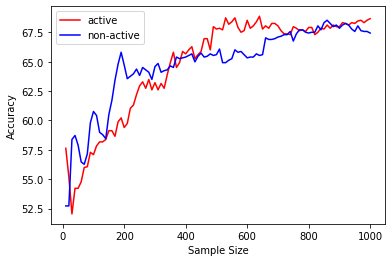

In [9]:
experiment(LogModel,MarginSelection,1000,10)